In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from tensorflow.keras import Model
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Embedding, Dense, Dropout, LSTM, Input, Concatenate, SpatialDropout1D
#from keras import Sequential
#from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, Dropout, Bidirectional, LSTM
#from keras.layers import  CuDNNLSTM
#from keras.layers.merge import concatenate

In [51]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"

In [52]:
from tensorflow import random
random.set_seed(42)

In [53]:
train = pd.read_csv('C:/Users/Donghyeok/Desktop/Work Folder/Reddit Sarcasm Detection/train-balanced-sarcasm.csv')

In [54]:
test = pd.read_csv('C:/Users/Donghyeok/Desktop/Work Folder/Reddit Sarcasm Detection/test-balanced.csv')

In [55]:
train

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [56]:
train = train.dropna(subset=['comment'])

In [57]:
train

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [58]:
def remove_punc(comment):
    '''This function uses str methods from the string class to remove punctuation from the text.'''
    
    # replace punctuation with '' (no space)
    translator = str.maketrans('', '', string.punctuation)
    
    # return the text stripped of punctuation marks
    return comment.translate(translator)

In [59]:
train['comment'] = train['comment'].apply(remove_punc)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,They were underdogs earlier today but since Gr...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,This meme isnt funny none of the new york nigg...,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [60]:
# load stopwords from NLTK
stopwords_eng = stopwords.words('english')
# view stop words
np.array(stopwords_eng)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [61]:
def remove_stopwords_and_lowercase(comment):
    '''This function lowercases words and then remove stopwords.'''
    
    comment = \
    [word.lower() for word in comment.split() if word.lower() not in stopwords_eng]
    return ' '.join(comment)

In [62]:
# Apply the function to each comment
train['comment'] = train['comment'].apply(remove_stopwords_and_lowercase)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west teams play west teams east teams right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdogs earlier today since gronks announcem...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funny none new york nigga ones,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tools,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [63]:
stemmer = SnowballStemmer('english')

def stem_each_word(text):
    '''This function stems each word in `text`'''
    
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

In [64]:
# apply stem_each_word function to each TRAIN and TEST comment

# TRAIN
train['comment'] = train['comment'].apply(stem_each_word)
train.head()


C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west team play west team east team right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdog earlier today sinc gronk announc afte...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funni none new york nigga one,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tool,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [65]:
lemmatizer = WordNetLemmatizer()

def lemmatize_each_word(text):
    '''This function lemmatizes each word, e.g., 
    - Remove the final "s" or "es" to singularize plurals and change person of some verbs
      (gets --> get,
      passes --> pass, 
      BUT not always as expected: 
      does --> doe (a deer, a female deer), 
      capitalizes --> captializes)
    '''
    text = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(text)

In [66]:
# apply lemmatize_each_word(text) function to each TRAIN and TEST comment

# TRAIN
train['comment'] = train['comment'].apply(lemmatize_each_word)
train.head()

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,nc nh,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,know west team play west team east team right,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,underdog earlier today sinc gronk announc afte...,Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,meme isnt funni none new york nigga one,icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,could use one tool,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [67]:
#Choose Random samples (fixed number) and concatenate - Shuffles + sample size:
sample_df_idx1 = np.random.choice(train.loc[train['label']==0].index, int(len(train.loc[train['label']==0].index)*0.5))
sample_df_idx2 = np.random.choice(train.loc[train['label']==1].index, int(len(train.loc[train['label']==1].index)*0.5))
sample_df_idx = np.concatenate((sample_df_idx1, sample_df_idx2))

In [155]:
np.savetxt("no_lemstem_index.csv",sample_df_idx, delimiter=",")

In [68]:
comments = train['comment'].loc[sample_df_idx]
labels = train['label'].loc[sample_df_idx]

In [69]:
embedding_dim = 16
vocab_size = 8000
length = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(comments)

word_index = tokenizer.word_index

train_seq = tokenizer.texts_to_sequences(comments)
train_pad = pad_sequences(train_seq, maxlen=length, padding='post', truncating='post')

In [70]:
train_seq = np.array(train_seq)
train_pad = np.array(train_pad)
labels = np.array(labels)

C:\Users\Donghyeok\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [71]:

# tokenized_comments = tokenize_text(comments, vocab_size)
# length = max_length(comments)
# main_vocab_size = len(tokenized_comments.word_index) + 1
# print('Max document length: %d' % length)
# print('Vocabulary size: %d' % vocab_size)

In [148]:
#Holdout validation set
X_train, X_test, y_train, y_test = train_test_split(train_pad, labels, test_size=0.2, random_state=24)


In [25]:
model = Sequential()
model.add(Embedding(vocab_size + 1, embedding_dim, input_length=length))
model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           128016    
_________________________________________________________________
lstm (LSTM)                  (None, 256)               279552    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 407,825
Trainable params: 407,825
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

101078/1 - 45s - loss: 0.6928 - accuracy: 0.4994
Untrained model, accuracy: 49.94%


In [28]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [29]:
checkpoint_path = "training_2/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [30]:
# # Loads the weights
# model.load_weights(checkpoint_path)

# # Re-evaluate the model
# loss, acc = model.evaluate(X_test, y_test, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

In [31]:
num_epochs = 100
batch_size = 95

history = model.fit(X_train, y_train, validation_split=0.2, epochs=num_epochs, batch_size=100, verbose=1, callbacks=[es, cp_callback])


Train on 323446 samples, validate on 80862 samples
Epoch 1/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6573 - accuracy: 0.5924
Epoch 00001: saving model to training_2/cp.ckpt
323446/323446 [==============================] - 133s 411us/sample - loss: 0.6573 - accuracy: 0.5925 - val_loss: 0.6222 - val_accuracy: 0.6550
Epoch 2/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6126 - accuracy: 0.6647
Epoch 00002: saving model to training_2/cp.ckpt
323446/323446 [==============================] - 128s 397us/sample - loss: 0.6126 - accuracy: 0.6646 - val_loss: 0.6248 - val_accuracy: 0.6530
Epoch 3/100
323300/323446 [============================>.] - ETA: 0s - loss: 0.6061 - accuracy: 0.6695
Epoch 00003: saving model to training_2/cp.ckpt
323446/323446 [==============================] - 126s 390us/sample - loss: 0.6061 - accuracy: 0.6695 - val_loss: 0.6072 - val_accuracy: 0.6668
Epoch 4/100
323300/323446 [============================>.] - ETA: 0

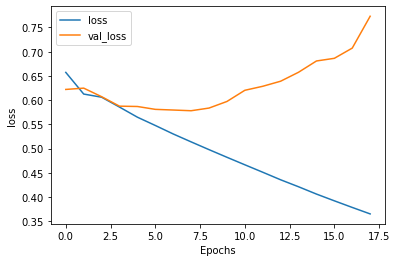

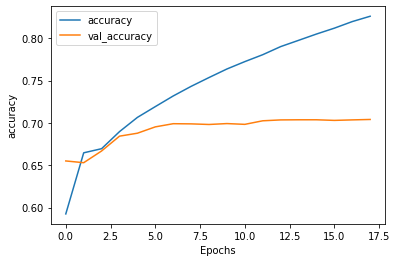

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [33]:
model.save('lstm_model_no_stemlem')

INFO:tensorflow:Assets written to: lstm_model_no_stemlem\assets


In [156]:
new_model = tf.keras.models.load_model('lstm_model')

In [157]:
# Evaluate the model
loss, acc = new_model.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * acc))

43776/1 - 69s


KeyboardInterrupt: 

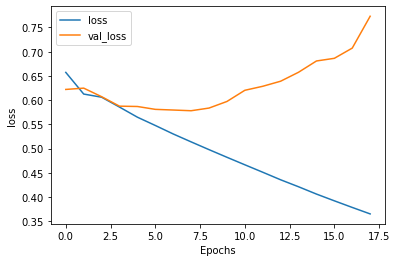

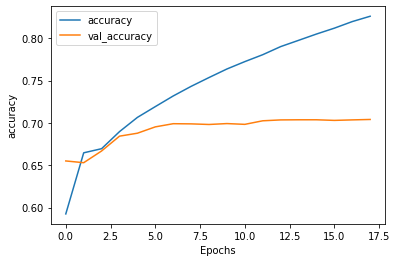

In [150]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [151]:
plt.plot(new_model.history['loss'])
plt.plot(new_model.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(new_model.history['accuracy'])
plt.plot(new_model.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

AttributeError: 'Sequential' object has no attribute 'history'

In [ ]:
plt.plot(lstm.history['loss'])
plt.plot(lstm.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()
  
plt.plot(lstm.history['accuracy'])
plt.plot(lstm.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

In [152]:
predictions = new_model.predict(X_test)

ValueError: Could not find matching function to call loaded from the SavedModel. Got:
  Positional arguments (1 total):
    * Tensor("inputs:0", shape=(None, 100), dtype=int32)
  Keyword arguments: {}

Expected these arguments to match one of the following 1 option(s):

Option 1:
  Positional arguments (1 total):
    * TensorSpec(shape=(None, 100), dtype=tf.float32, name='inputs')
  Keyword arguments: {}

In [ ]:
y_pred = predictions > 0.5

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
matrix = confusion_matrix(y_test, y_pred)

In [ ]:
tn, fp, fn, tp = matrix.ravel()

In [ ]:
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [ ]:
print(classification_report(y_test, y_pred))

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.naive_bayes import MultinomialNB

In [85]:
X_train, X_test, y_train, y_test = train_test_split(comments, labels)

In [ ]:
precision_recall_fscore_support(y_test, y_pred)

In [136]:
tfidf_unigram = TfidfVectorizer(ngram_range=(1,1), max_features=50000, min_df=2)
tfidf_bigram = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=2)

In [137]:
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', 
                           random_state=24, verbose=1)

In [138]:
tfidf_unigram_pipe = Pipeline([('tfidf_unigram', tfidf_unigram), 
                                 ('logit', logit)])
tfidf_unigram_pipe.fit(X_train, y_train)
uni_val_pred = tfidf_unigram_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, uni_val_pred))
print(classification_report(y_test, uni_val_pred))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.0s finished


accuracy: 0.6788051952163486
              precision    recall  f1-score   support

           0       0.67      0.71      0.69     63209
           1       0.69      0.64      0.67     63138

    accuracy                           0.68    126347
   macro avg       0.68      0.68      0.68    126347
weighted avg       0.68      0.68      0.68    126347



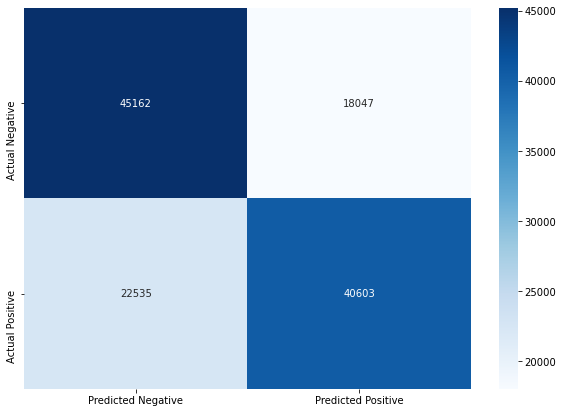

In [139]:
matrix = confusion_matrix(y_test, uni_val_pred)
tn, fp, fn, tp = matrix.ravel()
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [140]:
tfidf_bigram_pipe = Pipeline([('tfidf_bigram', tfidf_bigram), 
                                 ('logit', logit)])
tfidf_bigram_pipe.fit(X_train, y_train)
bi_val_pred = tfidf_bigram_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, bi_val_pred))
print(classification_report(y_test, bi_val_pred))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    7.1s finished


accuracy: 0.6992726380523479
              precision    recall  f1-score   support

           0       0.69      0.73      0.71     63209
           1       0.71      0.67      0.69     63138

    accuracy                           0.70    126347
   macro avg       0.70      0.70      0.70    126347
weighted avg       0.70      0.70      0.70    126347



In [141]:
matrix = confusion_matrix(y_test, bi_val_pred)

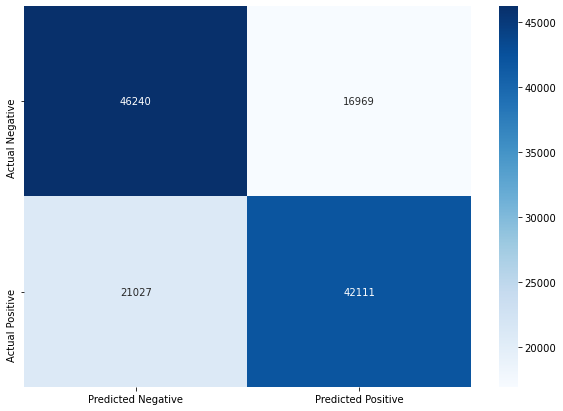

In [142]:
tn, fp, fn, tp = matrix.ravel()
df_cm = pd.DataFrame(matrix, index = ["Actual Negative", "Actual Positive"],
                      columns = ["Predicted Negative", "Predicted Positive"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap="Blues")

In [143]:
NB = MultinomialNB()

In [144]:
tfidf_unigram_NB_pipe = Pipeline([('tfidf_unigram', tfidf_unigram), 
                                 ('NB', NB)])
tfidf_unigram_NB_pipe.fit(X_train, y_train)
uni_val_NB_pred = tfidf_unigram_NB_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, uni_val_NB_pred))
print(classification_report(y_test, uni_val_NB_pred))

accuracy: 0.6601106476608072
              precision    recall  f1-score   support

           0       0.66      0.65      0.66     63209
           1       0.66      0.67      0.66     63138

    accuracy                           0.66    126347
   macro avg       0.66      0.66      0.66    126347
weighted avg       0.66      0.66      0.66    126347



In [145]:
tfidf_bigram_NB_pipe = Pipeline([('tfidf_unigram', tfidf_bigram), 
                                 ('NB', NB)])
tfidf_bigram_NB_pipe.fit(X_train, y_train)
bi_val_NB_pred = tfidf_bigram_NB_pipe.predict(X_test)
print("accuracy:", accuracy_score(y_test, bi_val_NB_pred))
print(classification_report(y_test, bi_val_NB_pred))

accuracy: 0.6769927263805234
              precision    recall  f1-score   support

           0       0.67      0.69      0.68     63209
           1       0.68      0.66      0.67     63138

    accuracy                           0.68    126347
   macro avg       0.68      0.68      0.68    126347
weighted avg       0.68      0.68      0.68    126347



In [135]:
print(classification_report(y_test, bi_val_NB_pred))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     63209
           1       0.68      0.66      0.67     63138

    accuracy                           0.68    126347
   macro avg       0.68      0.68      0.68    126347
weighted avg       0.68      0.68      0.68    126347

